## This notebook contains a example of temporal series Prediction applied to a wind velocity dataset

The data is splited on 2 separeted archieves

In [1]:
import numpy as np
import pandas as pd
import keras
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from pprint import pprint
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


Using TensorFlow backend.
/home/rodrigo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rodrigo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rodrigo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rodrigo/.local/lib/python3.6/site-packages/tensorflow/py

## Importing the data

In [2]:
data_csv = "wind_1.csv"
dataframe = pd.read_csv(data_csv, header=None)
wind_april = dataframe.values

data_csv = "wind_2.csv"
dataframe = pd.read_csv(data_csv, header=None)
wind_may = dataframe.values


## In order to select the Neural Network features the series autocorrelation must be checked

That way we can define the feature window size, selecting the lags that must be in or out of it.

 Lags analysed      :[0, 1, 2, 3, 4, 5, 17, 150]
 Linear correlation :[1.         0.96151483 0.93217717 0.91101969 0.89143141 0.87493881
 0.72735924 0.24894438]


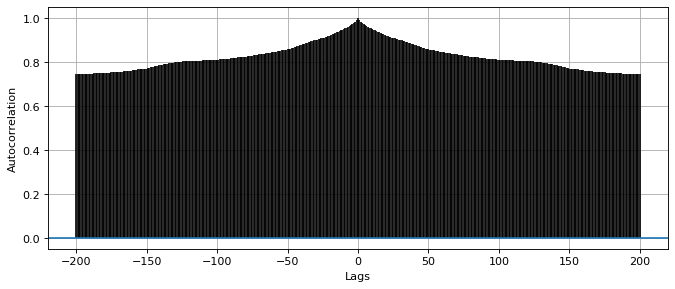

In [3]:
# The data
wind_april = np.array(wind_april).flatten()
wind_may   = np.array(wind_may).flatten()

# Lags array
Lags = [0, 1, 2, 3, 4, 5, 17, 150]
start = Lags[-1]
end = len(wind_april)

# Lag matrix
lag_matrix = [wind_april[start - i : end - i] for i in Lags]
linear_corr = np.corrcoef(lag_matrix, lag_matrix)[0][:len(Lags)]
print(" Lags analysed      :{0}".format(Lags))
print(" Linear correlation :{0}".format(linear_corr))


plt.figure(figsize=(10, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.xcorr(wind_april,wind_april, maxlags=200)
plt.ylabel('Autocorrelation')
plt.xlabel('Lags')
plt.grid(True)
plt.show()

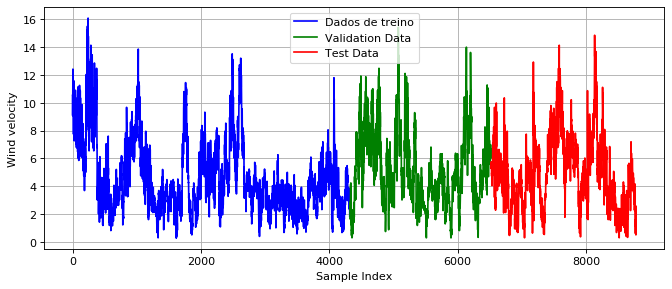

In [4]:
plt.figure(figsize=(10, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(wind_april,'b',label='Dados de treino')
plt.plot(np.arange(len(wind_april),len(wind_april)+2200),wind_may[:2200],'g',label='Validation Data')
plt.plot(np.arange(len(wind_april)+2200,len(wind_april)+len(wind_may)),wind_may[2200:],'r',label='Test Data')
plt.ylabel('Wind velocity')
plt.xlabel('Sample Index')
plt.legend()
plt.grid(True)
plt.show()

## Spliting the dataset in train, validation and test 

In [5]:
# Split the dataset in train, validation and test
# Split the dataset
Lags = np.arange(1,125)
start = Lags[-1]
end = 4320
x_train = [wind_april[start - i : end - i] for i in Lags]
y_train = wind_april[start:end]

start = Lags[-1]
end = 2200
x_val = [wind_may[start - i : end - i] for i in Lags]
y_val = wind_may[start:end]

start = 2201
end = 4460
x_test = [wind_may[start - i : end - i] for i in Lags]
y_test = wind_may[start:end]


In [6]:
class_1  = [len(wind_april),0,0,len(wind_april)]
class_2  = [0,2200,4460-2201,len(wind_may)]
n_data = len(wind_april) + len(wind_may)
total    = [len(wind_april),2200,4460-2201,n_data]
porcentagem = [len(wind_april)*100/n_data,2200*100/n_data,(4460-2201)*100/n_data,100]
table_df = {'Data': ['Train','Validation','Test','Total'],'Percent':porcentagem, 'April': class_1,'May': class_2,'Total':total}
table_df = pd.DataFrame(data=table_df)
table_df.to_csv('divisao_de_dados')
table_df

,Data,Percent,April,May,Total
0,Train,49.202733,4320,0,4320
1,Validation,25.056948,0,2200,2200
2,Test,25.728929,0,2259,2259
3,Total,100.000000,4320,4460,8780


## Dataset Normalization
the normalization equation is as follows:
$$  x'_i = \frac{(x_i-x_{min})*(L_{max}-L_{min})}{x_{max}-x_{min}} + L_{min}$$

In [7]:
# Normalize the datasets
min1 = np.min(x_train[0])
mawind_may = np.max(x_train[0])
min2 = np.min(x_train[1])
max2 = np.max(x_train[1])
x_train[0] = (x_train[0] - min1) / (mawind_may - min1)
x_train[1] = (x_train[1] - min2) / (mawind_may - min2)

min1 = np.min(x_val[0])
mawind_may = np.max(x_val[0])
min2 = np.min(x_val[1])
max2 = np.max(x_val[1])
x_val[0] = (x_val[0] - min1) / (mawind_may - min1)
x_val[1] = (x_val[1] - min2) / (mawind_may - min2)

min1 = np.min(x_test[0])
mawind_may = np.max(x_test[0])
min2 = np.min(x_test[1])
max2 = np.max(x_test[1])
x_test[0] = (x_test[0] - min1) / (mawind_may - min1)
x_test[1] = (x_test[1] - min2) / (mawind_may - min2)

x_test = np.transpose(x_test)
x_train = np.transpose(x_train)
x_val = np.transpose(x_val)

y_test = np.transpose(y_test)
y_train = np.transpose(y_train)
y_val = np.transpose(y_val)


## Building the arrificial neural network(ANN) and testing the results

In [8]:
# Building the NN
lr = 0.001  # learning rate
lr_decay = 0.0005# learning rate decay
n_mini_batch = 100  # mini-batch length
activation_fcn = "sigmoid"
optimizer = Adam(lr=lr, decay=lr_decay)
input_dim = x_train.shape[1]
h_n = 30
model = Sequential()
model.add(Dense(h_n, input_dim=input_dim, activation=activation_fcn))
model.add(Dense(1, activation="linear"))

# Compile model
model.compile(loss="mse", optimizer=optimizer, metrics=["accuracy"])

# Train and validate the model
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    batch_size=50,
    # verbose=0,
    callbacks=[
        EarlyStopping(
            monitor="val_loss", mode="min", min_delta=1, patience=20, verbose=1
        )
    ],
)







Train on 4196 samples, validate on 2076 samples
Epoch 1/200
4196/4196 [==============================] - 18s 4ms/step - loss: 7.3266 - acc: 0.0019 - val_loss: 6.7930 - val_acc: 4.8170e-04
Epoch 2/200
4196/4196 [==============================] - 0s 44us/step - loss: 5.1568 - acc: 0.0014 - val_loss: 5.3748 - val_acc: 0.0000e+00
Epoch 3/200
4196/4196 [==============================] - 0s 46us/step - loss: 4.2644 - acc: 0.0019 - val_loss: 4.7652 - val_acc: 9.6339e-04
Epoch 4/200
4196/4196 [==============================] - 0s 46us/step - loss: 3.6592 - acc: 0.0019 - val_loss: 4.2589 - val_acc: 0.0019
Epoch 5/200
4196/4196 [==============================] - 0s 46us/step - loss: 3.1797 - acc: 0.0031 - val_loss: 3.3752 - val_acc: 0.0014
Epoch 6/200
4196/4196 [==============================] - 0s 46us/step - loss: 2.8020 - acc: 0.0026 - val_loss: 3.1671 - val_acc: 0.0019
Epoch 7/200
4196/4196 [==============================] - 0s 45us/step - loss: 2.4886 - acc: 0.0052 - val_loss: 2.6056 

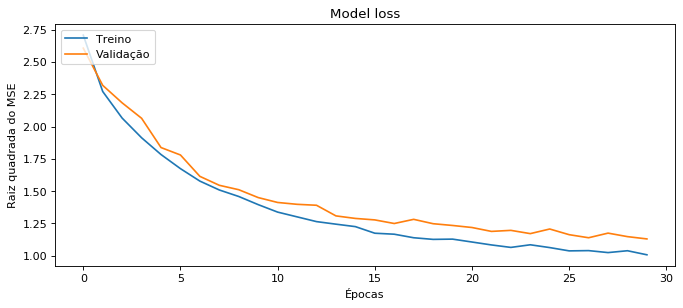

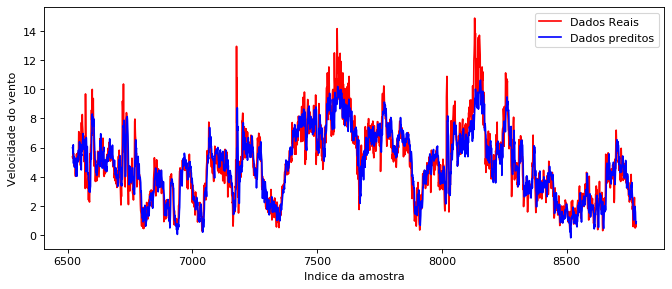

In [9]:
# Plot the validation and train loss
plt.figure(figsize=(10, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(np.sqrt(history.history["loss"]))
plt.plot(np.sqrt(history.history["val_loss"]))
plt.title("Model loss")
plt.ylabel("Raiz quadrada do MSE")
plt.xlabel("Épocas")
plt.legend(["Treino", "Validação"], loc="upper left")
plt.show()

pred = model.predict(x_test)
pred = np.array(pred).flatten()

plt.figure(figsize=(10, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(np.arange(len(wind_april)+2200,len(wind_april)+len(wind_may)-1),y_test.flatten(), 'r',label='Dados Reais')
plt.plot(np.arange(len(wind_april)+2200,len(wind_april)+len(wind_may)-1),pred.flatten(), 'b',label="Dados preditos")
plt.legend()
plt.ylabel('Velocidade do vento')
plt.xlabel('Indice da amostra')
plt.show()


## Testing different numbers of Neurons on the hidden layer

In [10]:
neurons = [5,10,15,30]
repetitions = 2
result = list()
for neuron in neurons:
    result_i = list()
    for i in range(0,repetitions):
        lr = 0.001  # learning rate
        lr_decay = 0.0005# learning rate decay
        n_mini_batch = 50  # mini-batch length
        activation_fcn = "sigmoid"
        optimizer = Adam(lr=lr, decay=lr_decay)
        input_dim = x_train.shape[1]
        h_n = neuron
        model = Sequential()
        model.add(Dense(h_n, input_dim=input_dim, activation=activation_fcn))
        model.add(Dense(1, activation="linear"))

        # Compile model
        model.compile(loss="mse", optimizer=optimizer, metrics=["accuracy"])

        # Train and validate the model
        history = model.fit(
            x_train,
            y_train,
            validation_data=(x_val, y_val),
            epochs=200,
            batch_size=n_mini_batch,
            # verbose=0,
            callbacks=[
                EarlyStopping(
                    monitor="val_loss", mode="min", min_delta=1, patience=10, verbose=1
                )
            ],
        )
        pred = model.predict(x_test)
        pred = np.array(pred).flatten()
        error = mean_squared_error(y_test,pred)
        result_i.append(error)
    result.append(result_i)

Train on 4196 samples, validate on 2076 samples
Epoch 1/200
4196/4196 [==============================] - 0s 87us/step - loss: 10.8993 - acc: 0.0086 - val_loss: 10.9411 - val_acc: 0.0029
Epoch 2/200
4196/4196 [==============================] - 0s 47us/step - loss: 7.8419 - acc: 0.0071 - val_loss: 9.8017 - val_acc: 0.0000e+00
Epoch 3/200
4196/4196 [==============================] - 0s 61us/step - loss: 7.3131 - acc: 0.0000e+00 - val_loss: 9.0004 - val_acc: 0.0000e+00
Epoch 4/200
4196/4196 [==============================] - 0s 47us/step - loss: 6.9967 - acc: 0.0000e+00 - val_loss: 8.4620 - val_acc: 0.0000e+00
Epoch 5/200
4196/4196 [==============================] - 0s 70us/step - loss: 6.7632 - acc: 2.3832e-04 - val_loss: 8.0936 - val_acc: 0.0000e+00
Epoch 6/200
4196/4196 [==============================] - 0s 47us/step - loss: 6.3700 - acc: 0.0012 - val_loss: 7.4763 - val_acc: 0.0000e+00
Epoch 7/200
4196/4196 [==============================] - 0s 45us/step - loss: 5.9878 - acc: 0.0014 - v

4196/4196 [==============================] - 0s 41us/step - loss: 3.8145 - acc: 0.0038 - val_loss: 4.3775 - val_acc: 4.8170e-04
Epoch 27/200
4196/4196 [==============================] - 0s 41us/step - loss: 3.6679 - acc: 0.0048 - val_loss: 4.2132 - val_acc: 9.6339e-04
Epoch 28/200
4196/4196 [==============================] - 0s 62us/step - loss: 3.5296 - acc: 0.0048 - val_loss: 4.0605 - val_acc: 9.6339e-04
Epoch 29/200
4196/4196 [==============================] - 0s 55us/step - loss: 3.4208 - acc: 0.0050 - val_loss: 3.9233 - val_acc: 9.6339e-04
Epoch 30/200
4196/4196 [==============================] - 0s 53us/step - loss: 3.3173 - acc: 0.0050 - val_loss: 3.9006 - val_acc: 0.0024
Epoch 31/200
4196/4196 [==============================] - 0s 67us/step - loss: 3.2155 - acc: 0.0048 - val_loss: 3.7418 - val_acc: 0.0024
Epoch 32/200
4196/4196 [==============================] - 0s 41us/step - loss: 3.1211 - acc: 0.0055 - val_loss: 3.6432 - val_acc: 0.0029
Epoch 33/200
4196/4196 [==============

4196/4196 [==============================] - 0s 73us/step - loss: 3.7465 - acc: 0.0033 - val_loss: 4.2067 - val_acc: 4.8170e-04
Epoch 15/200
4196/4196 [==============================] - 0s 46us/step - loss: 3.5523 - acc: 0.0033 - val_loss: 4.0980 - val_acc: 9.6339e-04
Epoch 16/200
4196/4196 [==============================] - 0s 46us/step - loss: 3.4414 - acc: 0.0029 - val_loss: 3.8425 - val_acc: 4.8170e-04
Epoch 17/200
4196/4196 [==============================] - 0s 40us/step - loss: 3.2309 - acc: 0.0038 - val_loss: 3.6730 - val_acc: 9.6339e-04
Epoch 18/200
4196/4196 [==============================] - 0s 51us/step - loss: 3.0936 - acc: 0.0043 - val_loss: 3.4841 - val_acc: 9.6339e-04
Epoch 19/200
4196/4196 [==============================] - 0s 76us/step - loss: 2.9324 - acc: 0.0036 - val_loss: 3.2214 - val_acc: 9.6339e-04
Epoch 20/200
4196/4196 [==============================] - 0s 51us/step - loss: 2.8392 - acc: 0.0031 - val_loss: 3.0973 - val_acc: 4.8170e-04
Epoch 21/200
4196/4196 [==

4196/4196 [==============================] - 0s 47us/step - loss: 2.8181 - acc: 0.0026 - val_loss: 2.9411 - val_acc: 0.0014
Epoch 12/200
4196/4196 [==============================] - 0s 47us/step - loss: 2.6369 - acc: 0.0029 - val_loss: 2.7511 - val_acc: 0.0019
Epoch 13/200
4196/4196 [==============================] - 0s 42us/step - loss: 2.4796 - acc: 0.0031 - val_loss: 2.5935 - val_acc: 9.6339e-04
Epoch 14/200
4196/4196 [==============================] - 0s 44us/step - loss: 2.3436 - acc: 0.0050 - val_loss: 2.8014 - val_acc: 0.0024
Epoch 15/200
4196/4196 [==============================] - 0s 57us/step - loss: 2.2200 - acc: 0.0055 - val_loss: 2.3278 - val_acc: 0.0014
Epoch 16/200
4196/4196 [==============================] - 0s 51us/step - loss: 2.1163 - acc: 0.0062 - val_loss: 2.3823 - val_acc: 0.0024
Epoch 17/200
4196/4196 [==============================] - 0s 40us/step - loss: 2.0612 - acc: 0.0057 - val_loss: 2.1841 - val_acc: 0.0024
Epoch 18/200
4196/4196 [==========================

4196/4196 [==============================] - 0s 42us/step - loss: 1.7320 - acc: 0.0074 - val_loss: 2.0599 - val_acc: 0.0024
Epoch 14/200
4196/4196 [==============================] - 0s 44us/step - loss: 1.5972 - acc: 0.0086 - val_loss: 1.7887 - val_acc: 0.0029
Epoch 15/200
4196/4196 [==============================] - 0s 42us/step - loss: 1.5811 - acc: 0.0069 - val_loss: 1.7372 - val_acc: 0.0029
Epoch 16/200
4196/4196 [==============================] - 0s 42us/step - loss: 1.5061 - acc: 0.0074 - val_loss: 1.6853 - val_acc: 0.0024
Epoch 17/200
4196/4196 [==============================] - 0s 46us/step - loss: 1.4397 - acc: 0.0079 - val_loss: 1.6425 - val_acc: 0.0024
Epoch 18/200
4196/4196 [==============================] - 0s 44us/step - loss: 1.3670 - acc: 0.0086 - val_loss: 1.5917 - val_acc: 0.0029
Epoch 19/200
4196/4196 [==============================] - 0s 42us/step - loss: 1.3672 - acc: 0.0088 - val_loss: 1.5720 - val_acc: 0.0034
Epoch 20/200
4196/4196 [==============================

In [11]:
result = np.array(result).reshape((len(neurons),repetitions))

In [12]:
mean = [np.mean(i) for i in result]
acc  = np.array(result) 
mean_acc = np.array(mean)

result_dict = {'neurons': neurons, 'results_1': result[:,0],'results_2':result[:,1], 'mean': mean, 'MSE1' : acc[:,0],'MSE2' : acc[:,1] , 'mean_mse': mean_acc}
result_df = pd.DataFrame(data=result_dict)
result_df.to_csv('results.csv')
result_df


,neurons,results_1,results_2,mean,MSE1,MSE2,mean_mse
0,5,2.567098,2.565595,2.566347,2.567098,2.565595,2.566347
1,10,1.906882,1.947048,1.926965,1.906882,1.947048,1.926965
2,15,1.595758,1.526331,1.561044,1.595758,1.526331,1.561044
3,30,1.664440,1.546588,1.605514,1.664440,1.546588,1.605514
